# Optimization, gradient descent, VJP, and all that

## Introduction

Suppose we wanted to optimize the following function:
$$
f(x,y, k) = || x + 2 y - k ||^2,
$$
where $x$, $y$, and $k$ are vectors.

We can calculate this via the `vectoradd_jax` tesseract; it is very similar to the old `vectoradd`, but it
has a more complicated schema that allows us to verify that nested structures work as expected.

It accepts inputs like 
```python
{
  "a": {"v": [1,2,3], "s": 1}, 
  "b": {"v": [4,5,6], "s": 2}
}
```
and returns two outputs, one with the sum, the other with the difference of `a.s * a.v` and `b.s * b.v`, both normalized and not.
As an example, for the inputs above, it returns 
```python
{
    "vector_add": {
        "result": [9.0, 12.0, 15.0],
        "normed_result": [0.42426407, 0.56568545, 0.70710677],
    },
    "vector_min": {
        "result": [-7.0, -8.0, -9.0],
        "normed_result": [-0.50257069, -0.57436651, -0.64616233],
    },
}
```
One can then see that our old $vectoradd$ function is still there, in `vector_add.result`, provided that `b.s = 1`.
```
vectoradd(a, b, s) = vectoradd_jax({"a": {"v": a, "s": s}, "b": {"v": b, "s": 1}})["vector_add"]["result"]
```
Let's then rewrite $f$ in terms of vectoradd:
$$
f(x, y, k) = || vectoradd(k, vectoradd(y, x, 2), -1) ||^2 
$$

Suppose that, after setting y and a to some constant values like $y = (1,2,3)$ and $k = (4,5,6)$,
we wanted to find the $x$ that minimizes this function. We can try to do so via gradient descent,
but we need to calculate the gradient of f with respect to x. We can do so via the chain rule; firstly,
for the outermost squared-norm operation, we can apply this elementary rule:
$$
\partial || z ||^2/\partial x = 2 z \partial z / \partial x
$$
Then, continuing to derive what's inside of that norm, and calling $u = vectoradd(k, v, -1)$ and $v = vectoradd(y, x, 2)$ for convenience, we arrive at:
$$
\frac{\partial  f}{\partial  x} = \left[\frac{\partial  f}{\partial  u} \frac{\partial  u}{\partial  v}\right] \frac{\partial v}{\partial x}.
$$
Notice the parentheses we inserted in order to pick a definite order in which to do the operations. We will see now that this
corresponds to using VJPs, and work in the so-called "backward mode". Had we grouped the operations in the opposite order, 
$\frac{\partial  f}{\partial  u} \left[ \frac{\partial  u}{\partial  v} \frac{\partial v}{\partial x} \right]$, we would be doing
"forward mode" autodiff, and we would need JVPs instead.

We can now proceed as follows:
  1.  We do a "forward" calculation, i.e.: we calculate the values of $v$, $u$, and $f$
  2.  We can see $\frac{\partial  f}{\partial  u} \frac{\partial  u}{\partial  v}$ as multiplying a vector ($\frac{\partial  f}{\partial  u}$) with a Jacobian matrix ($\frac{\partial  u}{\partial  v}$); this is an operation which is exposed by `vectoradd_jax` via the `vector_jacobian_product` endpoint. We have been a bit easy on the notation, but notice also that the Jacobian is evaluated at the point $(k, v, -1)$
  3.  Let's call the output of the previous operation `r`; it's easy to veryfy that it is a vector, and we can again view $r \frac{\partial v}{\partial x}$ as a vjp.

## Python implementation

Let's implement the above in Python. We will be assuming that a `vectoradd_jax` tesseract is running at `localhost:59411`.

We can start by implementing a barebones client; let's test it by performing a vjp operation:

In [7]:
# In case some dependency is missing, this should be enough.
# ! pip install numpy matplotlib

In [8]:
import numpy as np
import requests


def vectoradd(a, b, s):
    response = requests.post(
        "http://localhost:59411/apply",
        json={
            "inputs": {
                "a": {"v": a, "s": s},
                "b": {"v": b},  # notice: s=1.0 by default.
            }
        },
    )

    # This relies on plain lists representation, and only serves
    # illustrative purposes. use the tesseract_core.Tesseract client
    # for anything serious.
    data = response.json()["vector_add"]["result"]["data"]["buffer"]
    return data


def vectoradd_vjp(a, b, s, vjp_input, cotangent, raw_response=False):
    response = requests.post(
        "http://localhost:59411/vector_jacobian_product",
        json={
            "inputs": {"a": {"v": a, "s": s}, "b": {"v": b}},
            "vjp_inputs": [vjp_input],
            "vjp_outputs": ["vector_add.result"],  # notice the nesting in the output
            "cotangent_vector": {"vector_add.result": cotangent},
        },
    )

    if raw_response:
        return response.json()
    else:
        return np.array(response.json()[vjp_input]["data"]["buffer"])


vectoradd_vjp(
    a=[1.0, 2.0, 3.0],
    b=[4.0, 5.0, 6.0],
    s=1.0,
    vjp_input="a.v",
    cotangent=[2.0, 4.0, 6.0],
    raw_response=True,
)

{'a.v': {'object_type': 'array',
  'shape': [3],
  'dtype': 'float32',
  'data': {'buffer': [2.0, 4.0, 6.0], 'encoding': 'json'}}}

How do we make sense of this response from the vjp endpoint? 
Well, the vjp was calculated w.r.t. the `a.v` input and that is the outermost key of this data structure. The value associated with it is the vector which is the result of multiplying the vectors in `cotangent_vector` (concatenated with each other) with the 
Jacobian matrix (restricted to the variables in `vjp_inputs` and `vjp_outputs`). The result has the same shape as `a.v`.

Another way to look at this is the following: as the vjp maps the cotangent space into the tangent space, its schema is 
essentially the same as the input schema. We decided
for technical reasons to have a "flatter" dictionary where the leaves we have in the input are not nested, thus the appeareance of
`a.v` rather than `{"a": {"v": ...}`.

Notice also that the Jacobian of vectoradd w.r.t. a is just the identity matrix. So the cotangent vector [2,4,6] multiplied by the identity will still be [2,4,6], which is exactly what we see above.

If some of this is still not clear, maybe see the live docs of the tesseract for more info on what the endpoints do; for instance go to http://localhost:59411/docs#operation/vector_jacobian_product_vector_jacobian_product_post

Let's now use the vjp to calculate the gradient

In [9]:
# constants
y = [1, 2, 3]
k = [4, 5, 6]


def grad(x):
    # forward pass
    v = vectoradd(y, x, 2)
    u = vectoradd(k, v, -1)
    f = sum(c**2 for c in u)  # noqa: F841

    # backward pass
    df_du = 2 * np.array(u)
    # notice vjp_input=="b", as that's the arg we need to take derivatives w.r.t.
    df_dv = vectoradd_vjp(k, v, -1, "b.v", df_du.tolist())
    # notice vjp_input=="b" again, as x appears in the second argument
    df_dx = vectoradd_vjp(y, x, 2, "b.v", df_dv.tolist())

    return df_dx


grad([0, 0, 0])

array([-4., -2.,  0.])

Does this result make sense? This function is easy enough to calculate the gradient of analytically; it is just:
$$
\frac{\partial f}{\partial x} = 2 (x + 2y - k)
$$

In [10]:
2 * (2 * np.array(y) - np.array(k))

array([-4, -2,  0])

It checks out. Notice that in this simple example we could have skipped some steps, but we decided to ignore the fact that vectoradd is a linear function.

## Optimization

Finally, let's see what happens when we initialize `x` at a random value and then optimize it using gradient descent:

In [11]:
x = np.random.uniform(-5, 5, size=3)  # noqa: NPY002
alpha = 0.05


history = []
for _ in range(50):
    df_dx = grad(x.tolist())
    x -= alpha * df_dx
    history.append(x.copy())

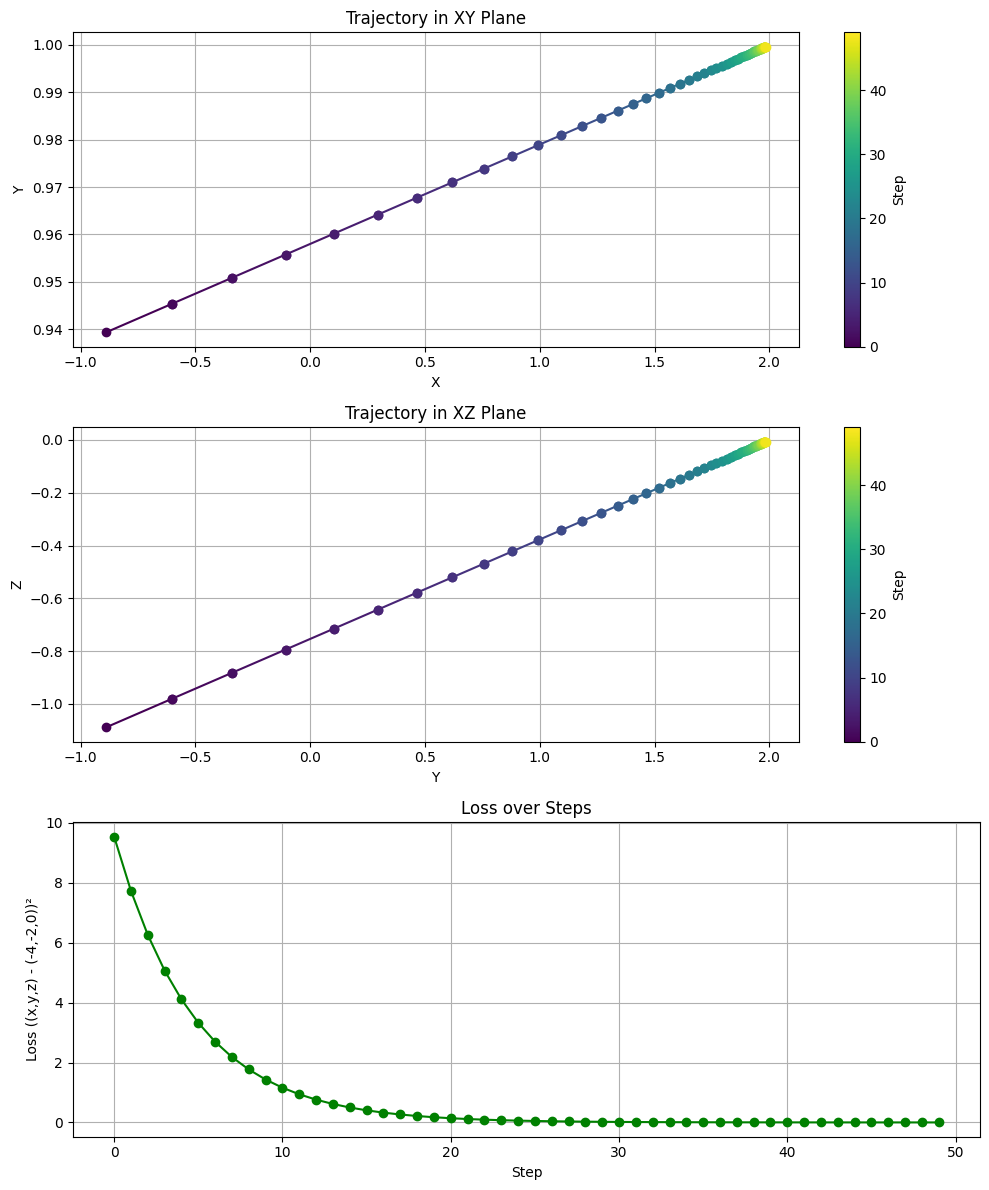

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

optimum = np.array([2, 1, 0])

traj_array = np.array(history)
loss = np.sum((traj_array - optimum) ** 2, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=len(history) - 1)

for i in range(len(history) - 1):
    ax1.plot(
        traj_array[i : i + 2, 0],
        traj_array[i : i + 2, 1],
        color=cmap(norm(i)),
        marker="o",
    )
ax1.set_title("Trajectory in XY Plane")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.grid(True)
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax1, label="Step")

for i in range(len(history) - 1):
    ax2.plot(
        traj_array[i : i + 2, 0],
        traj_array[i : i + 2, 2],
        color=cmap(norm(i)),
        marker="o",
    )
ax2.set_title("Trajectory in XZ Plane")
ax2.set_xlabel("Y")
ax2.set_ylabel("Z")
ax2.grid(True)
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax2, label="Step")

ax3.plot(range(len(loss)), loss, "g-o")
ax3.set_title("Loss over Steps")
ax3.set_xlabel("Step")
ax3.set_ylabel("Loss ((x,y,z) - (-4,-2,0))²")
ax3.grid(True)

plt.tight_layout()
plt.show()